<a href="https://colab.research.google.com/github/ysnarslan/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# import the libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [43]:
# visualization function
def show(tensor, ch=1, size=(28, 28), num=16):
    # tensor = batch_size (128) x image_size (784)
    data = tensor.detach().cpu().view(-1, ch, *size) # 128x1x28x28
    grid = make_grid(data[:num], nrow=4).permute(1, 2, 0) #16x1x28x28 -> 16x28x28x1
    plt.imshow(grid)
    plt.show()

In [44]:
# setup of the main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 300
mean_gen_losa = 0
mean_disc_loss = 0

z_dim = 64
lr = .00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=bs)

In [45]:
# Declare our models

## Generator
def genBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True)
    )


class Generator(nn.Module):
    def __init__(self, z_dim=64, i_dim=784, h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim), # 64, 128
            genBlock(h_dim, h_dim*2), # 128, 256
            genBlock(h_dim*2, h_dim*4), # 256, 512
            genBlock(h_dim*4, h_dim*8), # 512, 1024
            nn.Linear(h_dim*8, i_dim), # 1024, 784 (28, 28)
            nn.Sigmoid()
        )


    def forward(self, noise):
        return self.gen(noise)


def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device)


## Discriminator
def discBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.LeakyReLU(0.2),
    )


class Discriminator(nn.Module):
    def __init__(self, i_dim=784, h_dim=256):
        super().__init__()
        self.disc = nn.Sequential(
            discBlock(i_dim, h_dim*4), # 784, 1024
            discBlock(h_dim*4, h_dim*2), # 1024, 512
            discBlock(h_dim*2, h_dim), # 512, 256
            nn.Linear(h_dim, 1) # 256, 1 (Fake or Real)
        )


    def forward(self, image):
        return self.disc(image)


In [46]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)


In [47]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [48]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [49]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])


torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([4, 6, 3, 8, 6, 3, 9, 9, 8, 3])


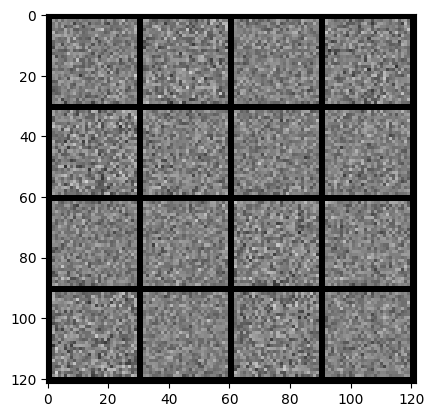

In [50]:
noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)


In [51]:
# Calculating loss

## Generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    pred = disc(fake)
    targets = torch.ones_like(pred)
    gen_loss = loss_func(pred, targets)
    return gen_loss

## Discriminator Loss
def calc_disc_loss(loss_func, gen, disc, real, number, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    disc_fake = disc(fake.detach())
    disc_fake_targets = torch.zeros_like(disc_fake)
    disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

    disc_real = disc(real)
    disc_real_targets = torch.ones_like(disc_real)
    disc_real_loss = loss_func(disc_real, disc_real_targets)

    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss


In [ ]:
# Training loop

for epoch in range(epochs):
    for real, _ in tqdm(dataloader):
        ## Discriminator
        disc_opt.zero_grad()
        cur_bs = len(real)
        real = real.view(cur_bs, -1) # bs (128) x image_size (784)
        real = real.to(device)

        disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, z_dim)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        ## Generator